In [2]:
import os, re
from dotenv import dotenv_values

from sqlalchemy import create_engine, text

from datetime import date,datetime,timedelta
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import requests

# Data Import
The data used to train the model has been prepared in the data_constitution.ipynb. The corresponding pickle file is imported

In [3]:
data = pd.read_pickle('../data/prepared_data.pkl')

# NN Model

In [5]:
from tensorflow.keras import models, layers, regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [7]:
feat_cols = [
    'mean_nitrate',
    'precipitation',
    'temperature',
    'maxwind',
    'sin_doy',
    'cos_doy',
]

DELTA = 60 # 60 days of previous weather used as features

for delta in range(1,DELTA+1) :
    feat_cols += [f'precipitation_{delta}']
    feat_cols += [f'temperature_{delta}']
    feat_cols += [f'maxwind_{delta}']

In [8]:
df = data.copy()

# Retreiving Validation Data
VAL_STATION = 6045800 # 6059500
val_rows = (df['station_id'] == VAL_STATION) & (df['day'] > datetime(year=2016,month=1,day=1))

df_val = df[val_rows].copy()
df = df[df['station_id'] != VAL_STATION].copy()
X_val = df_val[feat_cols]
y_val=df_val['measure']

# Features, Target
X = df[feat_cols]
y = df['measure']

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


In [10]:
def init_model(X_train):
    
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    regl2 = regularizers.L2(0.001)
    
    model = models.Sequential()
    
    model.add(normalizer)
    
    model.add( layers.Dense(200,activation='relu',input_dim=X_train.shape[1]) )
    model.add( layers.Dropout(rate=0.2) )
    model.add( layers.Dense(100,activation='relu',kernel_regularizer=regl2) )
    model.add(layers.Dropout(rate=0.3))
    
    model.add( layers.Dense(50,activation='relu',kernel_regularizer=regl2) )
    model.add(layers.Dropout(rate=0.5))
    
    
    model.add(layers.Dense(1,activation='linear'))
    
    return model

model = init_model(X_train)
model.compile(loss='mse', optimizer='adam')

es = EarlyStopping(
	patience=15,
	monitor='val_loss',
	restore_best_weights=True
)

history = model.fit(
	X_train,y_train,
	epochs=2000,  # set it to a large value, early stoping will stop the fit
	batch_size=32, # good values : 16 or 32
	callbacks=[es],
	validation_data=(X_test, y_test),
	verbose=0
)

val_loss_min = min(history.history['val_loss'])
print(f'{val_loss_min=}')

val_loss_min=5.457497596740723


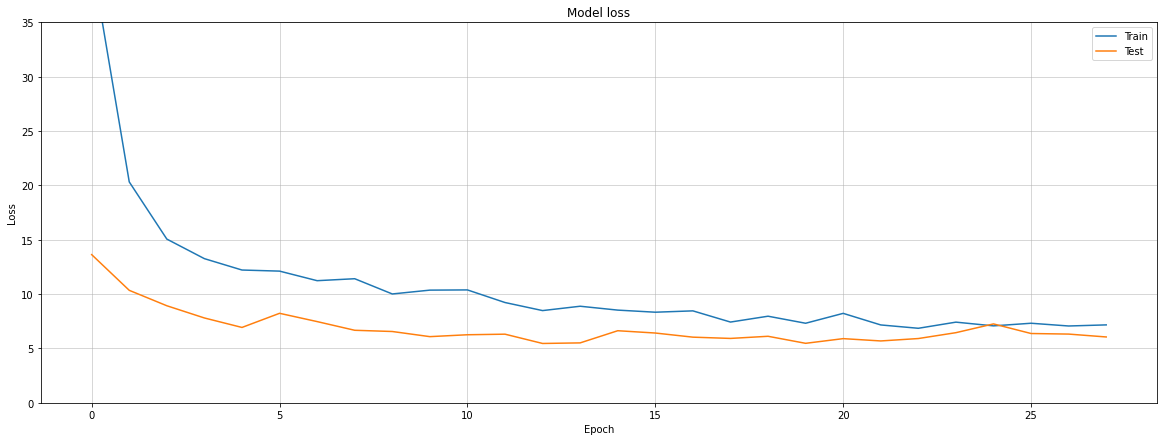

In [11]:
def plot_loss(history, title=None):
    fig = plt.figure(figsize=(20,7))
    
    # --- LOSS --- 
    ax = plt.gca()
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('Model loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylim((0,35))
    ax.legend(['Train', 'Test'], loc='best')
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

plot_loss(history)

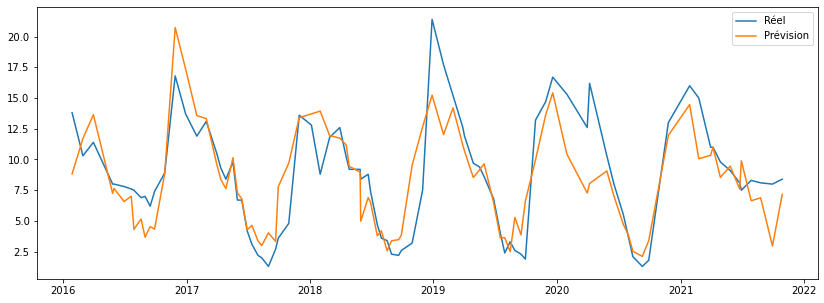

In [12]:
# Visually comparing Predicted Values and real values
# for a prediction done on unseen data
y_pred = model.predict(X_val)
df_val['prediction'] = y_pred

df_val.sort_values('day',inplace=True)

plt.figure(figsize=(14,5))
plt.plot(df_val['day'],df_val['measure'],label='Réel')
plt.plot(df_val['day'],df_val['prediction'],label='Prévision')
plt.legend()
plt.show()

In [29]:
model.save('../keras_model')

2022-02-11 11:59:31.734192: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../keras_model/assets
